# ROZDZIAL 3 - KLASYFIKACJA

## Zbior danych MNIST

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train.shape, y_train

((60000, 28, 28), array([5, 0, 4, ..., 5, 6, 8], dtype=uint8))

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
digt_8 = X_train[3600]

In [6]:
digt_5 = X_train[11]

Text(0.5, 1.0, '8')

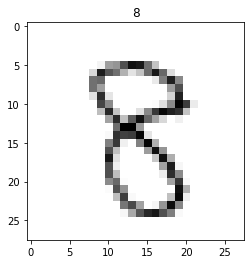

In [7]:
plt.imshow(digt_8, cmap=mpl.cm.binary, interpolation="nearest")
plt.title(y_train[3600], fontsize=12)

Text(0.5, 1.0, '5')

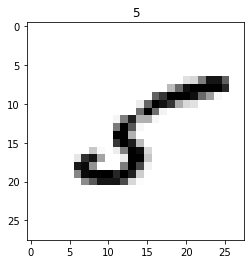

In [8]:
plt.imshow(digt_5, cmap=mpl.cm.binary, interpolation="nearest")
plt.title(y_train[11], fontsize=12)

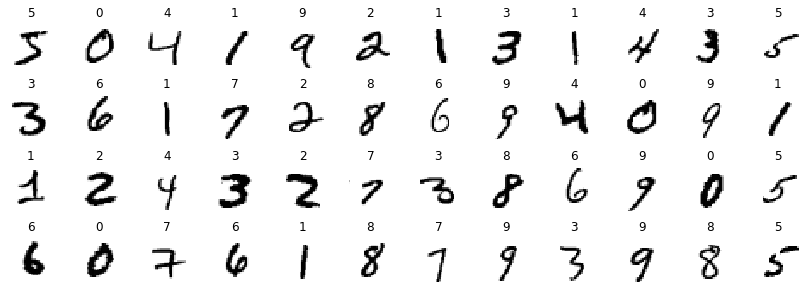

In [9]:
n_rows = 4
n_cols = 12
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap=mpl.cm.binary, interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
import numpy as np

In [11]:
shuffle_index = np.random.permutation(X_train.shape[0])

In [12]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index] # przetasowanie indeksów"

In [13]:
nsamples, nx, ny = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny))

In [14]:
X_train = X_train.reshape((nsamples,nx*ny))

## Klasyfiktaor binarny

In [15]:
# klasyfikacja jedynie piatek
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
y_test_5

array([False, False, False, ..., False,  True, False])

In [17]:
from sklearn.linear_model import SGDClassifier

In [18]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # klasyfikator stochastycznego spadku wzdluz gradinetu
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [19]:
sgd_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([False])

In [20]:
sgd_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona piatke

array([ True])

## Miary wydajności

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96385, 0.9594 , 0.9687 ])

In [23]:
# Własna implementacja cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [24]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96915
0.96435
0.9543


In [25]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [26]:
# XD bo tylko 10% danych to piatki
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90805, 0.9106 , 0.9103 ])

## Macierz pomylek

In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import  confusion_matrix

In [28]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [29]:
y_train_pred

array([False,  True, False, ..., False, False, False])

In [30]:
confusion_matrix(y_train_5, y_train_pred)

array([[53328,  1251],
       [  910,  4511]])

In [31]:
# TN  FP
# FN  TP

## Precyzja i Pelnosc

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [33]:
precision_score(y_train_5, y_train_pred)

0.7828878861506421

In [34]:
recall_score(y_train_5, y_train_pred)

0.8321342925659473

In [35]:
f1_score(y_train_5, y_train_pred)

0.8067602611106144

## Komporomis pomiedzy precyzja a pelnoscia

In [36]:
y_scores = sgd_clf.decision_function([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 5
y_scores

array([3358.74471576])

In [37]:
threshold = 2000
y_digit_5_predic = (y_scores > threshold)
y_digit_5_predic

array([ True])

In [38]:
threshold = 6000
y_digit_5_predic = (y_scores > threshold)
y_digit_5_predic

array([False])

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [40]:
from sklearn.metrics import precision_recall_curve

In [41]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [42]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precyzja", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Pełność", linewidth=2)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.xlabel("Próg", fontsize=16)

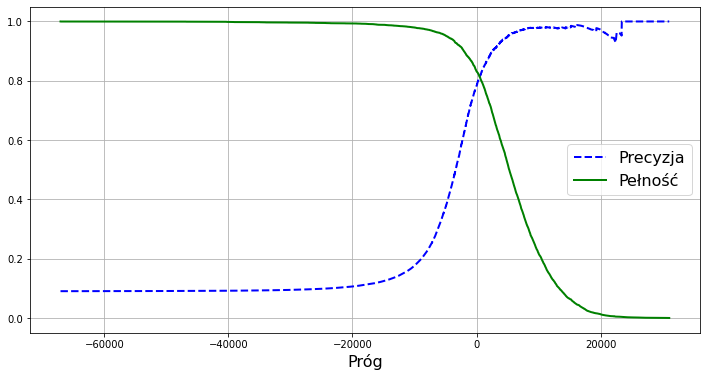

In [43]:
plt.figure(figsize=(12, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [44]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Pełność", fontsize=16)
    plt.ylabel("Precyzja", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

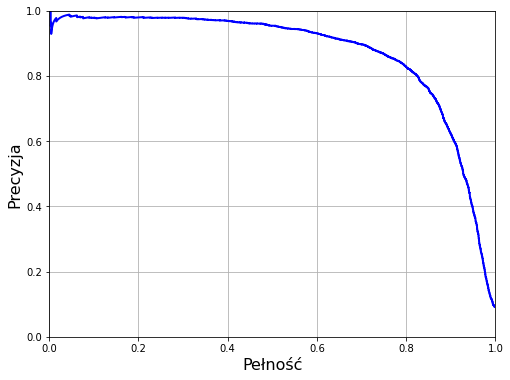

In [45]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

## Wykres krzywej ROC

In [46]:
from sklearn.metrics import roc_curve

In [47]:
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

In [48]:
def plot_roc_curve(fpr, tpr, label=None, color="b"):
    plt.plot(fpr, tpr, color, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.xlabel('Odsetek fałszywie pozytywnych', fontsize=16)
    plt.ylabel('Odsetek prawdziwie pozytywnych', fontsize=16)
    plt.grid(True)


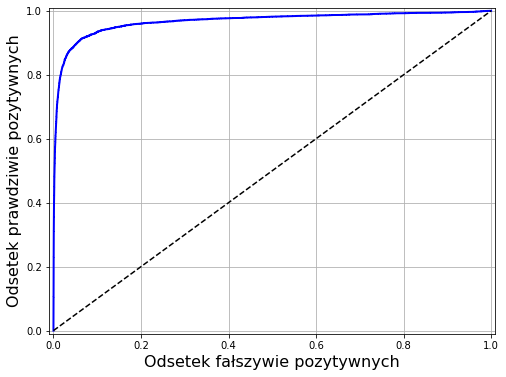

In [49]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

## RandomForest

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [52]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

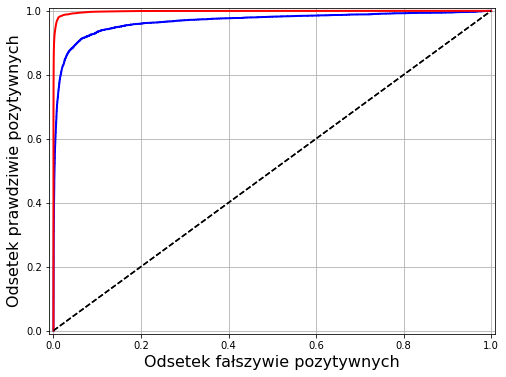

In [53]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr,  "SGD", "b")
plot_roc_curve(fpr_forest, tpr_forest, "Forest", "r")
plt.show()

In [54]:
from sklearn.metrics import roc_auc_score

In [55]:
roc_auc_score(y_train_5, y_scores)

0.9674537425055748

In [56]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983205804357271

In [57]:
y_train_pred_forest = cross_val_predict(forest_clf, d2_X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905601006922593

In [58]:
recall_score(y_train_5, y_train_pred_forest)

0.8710570005534034

## Klasyfkacja wieloklasowa

In [59]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # klasyfikator stochastycznego spadku wzdluz gradinetu
sgd_clf.fit(X_train, y_train) # klasyfifkatory same dobierają strategie OvA OvO gdy uzywamy klasyfikacji binarnej

SGDClassifier(random_state=42)

In [60]:
sgd_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([5], dtype=uint8)

In [61]:
sgd_clf.decision_function([digt_5.reshape((nx*ny,))])

array([[-22844.36597104, -20171.11914423,  -2394.35743749,
        -10742.0816171 ,  -6573.71344849,   3282.67739279,
        -13712.04429921, -12008.64478269,   1586.56894831,
         -7975.13916185]])

In [62]:
sgd_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 5

array([8], dtype=uint8)

In [63]:
digit_8_scores = sgd_clf.decision_function([digt_8.reshape((nx*ny,))])

In [64]:
digit_8_scores

array([[-14759.16003738, -25963.26145728,  -3141.81475438,
         -1534.20596286, -13138.73608943,  -5681.83051131,
         -9951.21163938,  -8867.58436949,    914.08227254,
         -4878.53032074]])

In [65]:
np.argmax(digit_8_scores)

8

In [66]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [67]:
sgd_clf.classes_[8]

8

## Bezpośrednie strategie OvA OvO

In [68]:
from sklearn.multiclass import OneVsOneClassifier

In [69]:
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=1000, tol=1e-3, random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [70]:
ovo_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([8], dtype=uint8)

In [71]:
ovo_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 5

array([5], dtype=uint8)

In [72]:
len(ovo_clf.estimators_) # 10*9/2 tyle kombinacji

45

In [73]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [74]:
forest_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([8], dtype=uint8)

In [75]:
forest_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 5

array([5], dtype=uint8)

In [76]:
forest_clf.predict_proba([digt_5.reshape((nx*ny,))])

array([[0.  , 0.  , 0.03, 0.01, 0.02, 0.92, 0.01, 0.  , 0.01, 0.  ]])

In [77]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8687 , 0.87105, 0.8502 ])

In [78]:
from sklearn.preprocessing import StandardScaler

In [79]:
# To nie dziala
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Analiza bledow

In [80]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5556,    1,   68,   38,   10,   49,   28,    8,  149,   16],
       [   3, 6518,   71,   16,    5,   30,    4,    6,   72,   17],
       [  36,   99, 5280,  145,   53,   31,   52,   47,  196,   19],
       [  22,   52,  415, 4683,   10,  514,   16,   32,  284,  103],
       [   9,   47,   60,   20, 5096,   18,   32,   19,  182,  359],
       [  37,   37,   64,  158,   49, 4530,   69,   11,  360,  106],
       [  33,   24,  117,   29,   58,  184, 5342,    3,  123,    5],
       [  24,   45,  145,  123,   87,   34,    5, 5147,  107,  548],
       [  34,  138,  250,  140,   33,  288,   32,   12, 4824,  100],
       [  29,   43,   61,   86,  287,   82,    4,  123,  411, 4823]])

<Figure size 576x432 with 0 Axes>

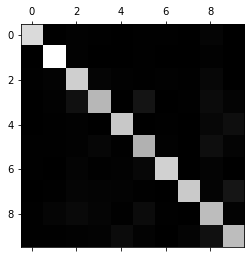

In [81]:
# Rzad to rzeczywiste klasy
# Kolumny to przewidywane
plt.figure(figsize=(8, 6))
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [82]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx /row_sums

In [83]:
np.fill_diagonal(norm_conf_mx, 0)

<Figure size 576x432 with 0 Axes>

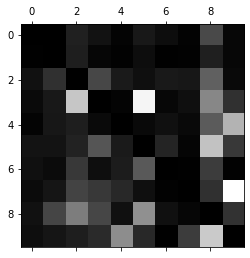

In [84]:
plt.figure(figsize=(8, 6))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Klasyfikacja wieloetykietowa

In [89]:
from sklearn.neighbors import KNeighborsClassifier

In [90]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [91]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()